# Import liberies

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functions import *
from pipeline import *

from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler 

from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Imbpipeline

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

# The Data

In [2]:
heartdf=pd.read_csv('heart_2020_cleaned.csv')

Manipulation that we did in the EDA part

In [3]:
heartdf3 = heartdf[(heartdf.SleepTime>=3)&(heartdf.SleepTime<=15)].drop_duplicates()

In [4]:
heartdf3.shape

(299908, 18)

# Model

First of all like we said in the EDA, the target is not balanced so we will use some methods to get the target balance.

We will use the under/over sampling and penalizing method.

And we will see which one is better of course we will try differnts models as well.

So First lets see the imbalanced ratio we have in the data.

In [5]:
counter = Counter(heartdf3.HeartDisease)
print(counter)

Counter({'No': 272918, 'Yes': 26990})


In [6]:
ratio=(26990/272918)*100
print(f'Imbalanced Ratio of Target: {ratio:.3f}')

Imbalanced Ratio of Target: 9.889


* Spliting the data into Train and Test

In [7]:
X=heartdf3.drop('HeartDisease',axis=1)
y=heartdf3['HeartDisease'].replace({'Yes':1,'No':0})

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, 
                                            random_state=951357)

* Columns to use in the transform

In [8]:
col_to_index = ['Smoking','Stroke','DiffWalking','Sex',
                                'Race','Diabetic','GenHealth',
                                'PhysicalActivity','KidneyDisease','SkinCancer'
                                # ,'AlcoholDrinking','Asthma'
                                ]

list_col = ['AgeCategory']

age_dict = {'18-24':18,'25-29':25,'30-34':30,'35-39':35,'40-44':40,'45-49':45,'50-54':50,'55-59':55,'60-64':60,
            '65-69':65,'70-74':70,'75-79':75,'80 or older':80}
list_dict = [age_dict]

drop_cols = ['AlcoholDrinking','Asthma','MentalHealth']

## 1. Without any imbalance method

* Pipelines:

In [9]:
pipeRF = Pipeline([('DropColumns', DropColumns(drop_cols)),
                    ('AddIndex', AddColumnIndex(col_to_index)),
                    ('AddGroup', AddColumnGroup(list_col,list_dict)),
                    ('scaler', StandardScaler()),
                    ('RF', RandomForestClassifier())
])
pipeXGB = Pipeline([('DropColumns',DropColumns(drop_cols)),
                    ('AddIndex',AddColumnIndex(col_to_index)),
                    ('AddGroup',AddColumnGroup(list_col,list_dict)),
                    ('scaler',StandardScaler()),
                    ('XGB',XGBClassifier())
])
                    

* Parameters to Grid Search

In [10]:
param_range = [3, 4, 9]
param_range2 = [2, 3, 5]
n_estimators = [30,40]

* Cross Validation

In [11]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

* Random Forest Model

In [12]:
parameters_RF08 = [{'RF__min_samples_leaf': param_range2,
                        'RF__max_depth': param_range,
                        'RF__n_estimators': n_estimators}]
modelRF08 = GridSearchCV(estimator=pipeRF,
                        param_grid=parameters_RF08,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelRF08.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292C7C74150>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292C8148490>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292C7B6BE50>),
                                       ('scaler', StandardScaler()),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'RF__max_depth': [3, 4, 9],
                          'RF__min_samples_leaf': [2, 3, 5],
                          'RF__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [13]:
printreport(modelRF08.best_estimator_, X_train, y_train)

Confusion Matrix:
        0    1
0  190918  191
1   18104  722

Precision: 0.791
Recall: 0.038
ROC AUC: 0.841
PR Curve: 0.379


* XGBoost Model

In [14]:
parameters_XGB = [{'XGB__max_depth': param_range,
                        'XGB__min_child_weight': param_range2,
                        'XGB__n_estimators': n_estimators}]

modelXGB08 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB08.fit(X_train,y_train)



GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292C784DBD0>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292C8148510>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292C8148410>),
                                       ('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [15]:

printreport(modelXGB08.best_estimator_, X_train, y_train)

Confusion Matrix:
        0     1
0  190033  1076
1   17199  1627

Precision: 0.602
Recall: 0.086
ROC AUC: 0.844
PR Curve: 0.364


## 1. Penalizing

We will try differents weights, the balanced weight and we will give some weights by ourself

In [16]:
pipeLR = Pipeline([('DropColumns',DropColumns(drop_cols)),
                   ('AddIndex',AddColumnIndex(col_to_index)),
                   ('AddGroup',AddColumnGroup(list_col,list_dict)),
                   ('scaler',StandardScaler()),
                   ('LR',LogisticRegression())
])


* Parameters to Grid Search

In [17]:
param_weight = [{0: 0.8, 1:9}, {0: 0.5, 1:5}, {0: 1, 1:10}, {0: 1, 1:9}, "balanced"]
scale_weights = [5,9,10]

* Logistic Regression Model

In [18]:
parameters_LR = [{'LR__class_weight': param_weight}]

modelLR = GridSearchCV(estimator=pipeLR,
                        param_grid=parameters_LR,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelLR.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292C7B7C150>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292C816D8D0>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292C816F310>),
                                       ('scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'LR__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced']}],
             scoring='roc_auc')

In [19]:
printreport(modelLR.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  134044  57065
1    3862  14964

Test Confusion Matrix:
       0      1
0  57589  24220
1   1767   6397

Train Precision: 0.208
Test Precision: 0.209

Train Recall: 0.795
Test Recall: 0.784

Train ROC AUC: 0.823
Test ROC AUC: 0.820

Train PR Curve: 0.324
Test PR Curve: 0.323


* Random Forest Model

In [20]:
parameters_RF = [{'RF__min_samples_leaf': param_range2,
                    'RF__max_depth': param_range,
                    'RF__n_estimators': n_estimators,
                    'RF__class_weight': param_weight}]
modelRF = GridSearchCV(estimator=pipeRF,
                        param_grid=parameters_RF,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelRF.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292C7C74150>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292C8148490>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292C7B6BE50>),
                                       ('scaler', StandardScaler()),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'RF__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced'],
                          'RF__max_depth': [3, 4, 9],
                          'RF__min_samples_leaf': [2, 3, 5],
                          'RF__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [21]:
printreport(modelRF.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  136378  54731
1    3399  15427

Test Confusion Matrix:
       0      1
0  58374  23435
1   1643   6521

Train Precision: 0.220
Test Precision: 0.218

Train Recall: 0.819
Test Recall: 0.799

Train ROC AUC: 0.843
Test ROC AUC: 0.830

Train PR Curve: 0.372
Test PR Curve: 0.341


* XGBoost Model

The model XGBClassifier doesn't have classes weights. 

So in this case we will try two ways, one is sample_weight in the fit and second one is parameter of XGBClassifier scale_pos_weight.

In [22]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
modelXGB1 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB1.fit(X_train,y_train, XGB__sample_weight=classes_weights)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292C784DBD0>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292C8148510>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292C8148410>),
                                       ('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40]}],
             scoring='roc_auc')

In [23]:
printreport(modelXGB1.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  137977  53132
1    3555  15271

Test Confusion Matrix:
       0      1
0  59080  22729
1   1710   6454

Train Precision: 0.223
Test Precision: 0.221

Train Recall: 0.811
Test Recall: 0.791

Train ROC AUC: 0.844
Test ROC AUC: 0.834

Train PR Curve: 0.360
Test PR Curve: 0.349


In [24]:
parameters_XGB2 = [{'XGB__max_depth': param_range,
                        'XGB__min_child_weight': param_range2,
                        'XGB__n_estimators': n_estimators,
                        'XGB__scale_pos_weight': scale_weights}]
modelXGB2 = GridSearchCV(estimator=pipeXGB,
                        param_grid=parameters_XGB2,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelXGB2.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292C784DBD0>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292C8148510>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292C8148410>),
                                       ('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40],
                          'XGB__scale_pos_weight': [5, 9, 10]}],
             scoring='roc_auc')

In [25]:
printreport(modelXGB2.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  141921  49188
1    3925  14901

Test Confusion Matrix:
       0      1
0  60741  21068
1   1879   6285

Train Precision: 0.233
Test Precision: 0.230

Train Recall: 0.792
Test Recall: 0.770

Train ROC AUC: 0.844
Test ROC AUC: 0.834

Train PR Curve: 0.361
Test PR Curve: 0.349


In this first part that we used Penalizing method to balanced the target.

The best model that we got is Random Forest. 

With a Recall of 0.815, AUC 0.768 and PR 0.199.


Now we are going to do the second part that is under/over sampling. 

## 2. Under/over Sampling

* Pipelines

In [26]:
pipeDT = Imbpipeline([('DropColumns',DropColumns(drop_cols)),
                        ('AddIndex',AddColumnIndex(col_to_index)),
                        ('AddGroup',AddColumnGroup(list_col,list_dict)),
                        ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                        ('under',RandomUnderSampler(sampling_strategy=0.5)),
                        ('scaler',StandardScaler()),
                        ('DT',DecisionTreeClassifier())
])

pipeLR2 = Imbpipeline([('DropColumns',DropColumns(drop_cols)),
                        ('AddIndex',AddColumnIndex(col_to_index)),
                        ('AddGroup',AddColumnGroup(list_col,list_dict)),
                        ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                        ('under',RandomUnderSampler(sampling_strategy=0.5)),
                        ('scaler',StandardScaler()),
                        ('LR',LogisticRegression())
])

pipeRF2 = Imbpipeline([('DropColumns',DropColumns(drop_cols)),
                        ('AddIndex',AddColumnIndex(col_to_index)),
                        ('AddGroup',AddColumnGroup(list_col,list_dict)),
                        ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                        ('under',RandomUnderSampler(sampling_strategy=0.5)),
                        ('scaler',StandardScaler()),
                        ('RF',RandomForestClassifier())
])

pipeXGB3 = Imbpipeline([('DropColumns',DropColumns(drop_cols)),
                        ('AddIndex',AddColumnIndex(col_to_index)),
                        ('AddGroup',AddColumnGroup(list_col,list_dict)),
                        ('over',SMOTE(sampling_strategy=0.1, k_neighbors=7)),
                        ('under',RandomUnderSampler(sampling_strategy=0.5)),
                        ('scaler',StandardScaler()),
                        ('XGB',XGBClassifier())
])

* Parameters to GridSearch

In [27]:
criterion = ['gini','entropy']
k = [1, 2, 3, 4, 5, 6, 7]

In [28]:
parameters_DT = {'DT__criterion': criterion,
                'DT__max_depth': param_range,
                'DT__min_samples_split': param_range2,
                'DT__min_samples_leaf': param_range2,
                'over__k_neighbors': k
                }       

modelDT = GridSearchCV(estimator=pipeDT, 
                       param_grid=parameters_DT,
                       n_jobs=-1, 
                       cv=cv, 
                       scoring='roc_auc')

modelDT.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292CAF97590>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292CAF941D0>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292D3A1E910>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('scaler', StandardScaler()),
                                       ('DT', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'DT__criterion': ['gini', 'entropy'],
                         'DT__max_depth': [3, 4, 9],
                         'DT__min_samples_leaf': [2, 3, 5],
                         'DT__min_samples_split': [2, 3, 5],
                         'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]},
             scoring='roc_auc')

In [29]:
printreport(modelDT.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  159020  32089
1    6877  11949

Precision: 0.271
Recall: 0.635
ROC AUC: 0.835
PR Curve: 0.319


In [30]:
parameters_LR2 = [{'LR__class_weight': param_weight,
                    'over__k_neighbors': k}]

modelLR2 = GridSearchCV(estimator=pipeLR2,
                        param_grid=parameters_LR2,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')
modelLR2.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292D3A1E1D0>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292D3A1D0D0>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292D3A1DDD0>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'LR__class_weight': [{0: 0.8, 1: 9}, {0: 0.5, 1: 5},
                                               {0: 1, 1: 10}, {0: 1, 1: 9},
                                               'balanced'],
                          'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc')

In [31]:
printreport(modelLR2.best_estimator_, X_train, y_train)

Confusion Matrix:
        0      1
0  138840  52269
1    4401  14425

Precision: 0.216
Recall: 0.766
ROC AUC: 0.823
PR Curve: 0.324


In [32]:
parameters_RF2 = [{'RF__min_samples_leaf': param_range2,
                    'RF__max_depth': param_range,
                    'RF__n_estimators': n_estimators,
                    'over__k_neighbors': k}]

modelRF2 = GridSearchCV(estimator=pipeRF2,
                        param_grid=parameters_RF2,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')

modelRF2.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292D3A1FDD0>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292D3A1D890>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292D3A1EAD0>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('scaler', StandardScaler()),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'RF__max_depth': [3, 4, 9],
                          'RF__min_samples_leaf': [2, 3, 5],
                          'RF__n_estimators': [30, 40],
                          'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc')

In [33]:
printreport(modelRF2.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  165979  25130
1    7864  10962

Test Confusion Matrix:
       0      1
0  71065  10744
1   3573   4591

Train Precision: 0.304
Test Precision: 0.299

Train Recall: 0.582
Test Recall: 0.562

Train ROC AUC: 0.840
Test ROC AUC: 0.830

Train PR Curve: 0.364
Test PR Curve: 0.340


In [34]:
parameters_XGB3 = [{'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range2,
                    'XGB__n_estimators': n_estimators,
                    'over__k_neighbors': k}]

modelXGB3 = GridSearchCV(estimator=pipeXGB3,
                        param_grid=parameters_XGB3,
                        n_jobs=-1, 
                        cv=cv,
                        scoring='roc_auc')

modelXGB3.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('DropColumns',
                                        <pipeline.DropColumns object at 0x00000292D3A1C290>),
                                       ('AddIndex',
                                        <pipeline.AddColumnIndex object at 0x00000292D3A1C8D0>),
                                       ('AddGroup',
                                        <pipeline.AddColumnGroup object at 0x00000292D3A1C510>),
                                       ('over',
                                        SMOTE(k_neighbors=7,
                                              sampling_strategy=0.1...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid=[{'XGB__max_depth': [3, 4, 9],
                          'XGB__min_child_weight': [2, 3, 5],
                          'XGB__n_estimators': [30, 40],
                          'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc')

In [35]:
printreport(modelXGB3.best_estimator_, X_train, y_train, X_test, y_test)

Train Confusion Matrix:
        0      1
0  162867  28242
1    7296  11530

Test Confusion Matrix:
       0      1
0  69774  12035
1   3252   4912

Train Precision: 0.290
Test Precision: 0.290

Train Recall: 0.612
Test Recall: 0.602

Train ROC AUC: 0.840
Test ROC AUC: 0.834

Train PR Curve: 0.351
Test PR Curve: 0.346


In [50]:
list_model = [modelLR,modelRF,modelXGB1,modelXGB2,modelDT,modelLR2,modelRF2,modelXGB3]
list_name_model = ['modelLR(weight)','modelRF(weight)','modelXGB(sample_weight)','modelXGB2(scale_pos_weight)','modelDT(Smote/RandomUnder)','modelLR(Smote/RandomUnder)'\
                    ,'modelRF(Smote/RandomUnder)','modelXGB(Smote/RandomUnder)']

In [79]:
result_table(list_model,list_name_model,X_test,y_test)

In [80]:
results_table

,Model,Recall,Precision,AUC,PR
0,modelLR(weight),0.783562,0.208936,0.819622,0.322685
1,modelRF(weight),0.798751,0.217686,0.829972,0.340863
2,modelXGB(sample_weight),0.790544,0.221156,0.834201,0.349451
3,modelXGB2(scale_pos_weight),0.769843,0.229774,0.834403,0.348840
4,modelDT(Smote/RandomUnder),0.601298,0.262809,0.816790,0.293855
5,modelLR(Smote/RandomUnder),0.756369,0.218198,0.819438,0.321925
6,modelRF(Smote/RandomUnder),0.562347,0.299381,0.830309,0.339845
7,modelXGB(Smote/RandomUnder),0.601666,0.289845,0.833699,0.346278


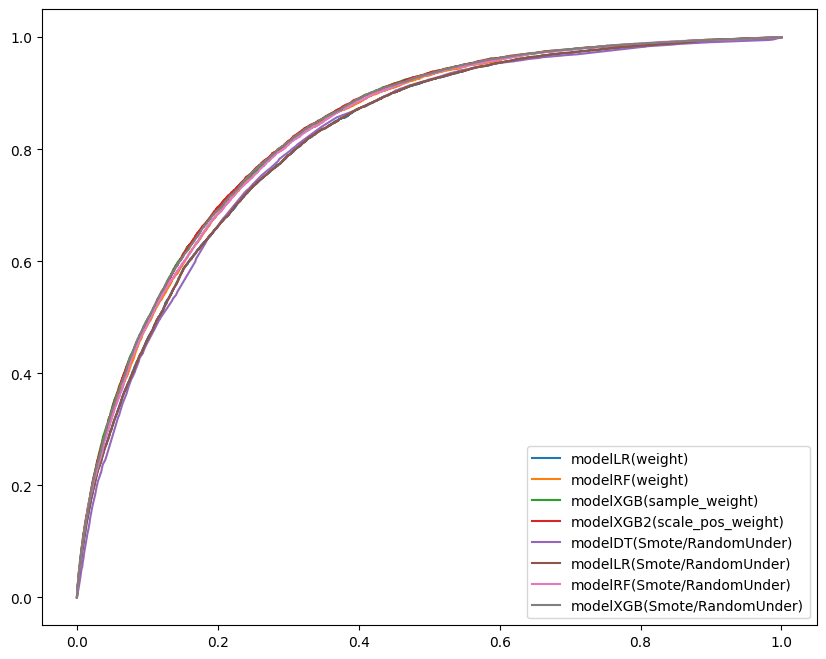

In [58]:
plt.figure(figsize=(10,8))
for i in range(len(list_model)):
    y_pred_proba = list_model[i].predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    # auc = roc_auc_score(y_test, y_pred_proba).round(3)
    plt.plot(fpr,tpr,label=list_name_model[i])
plt.legend(loc=4)
plt.show()

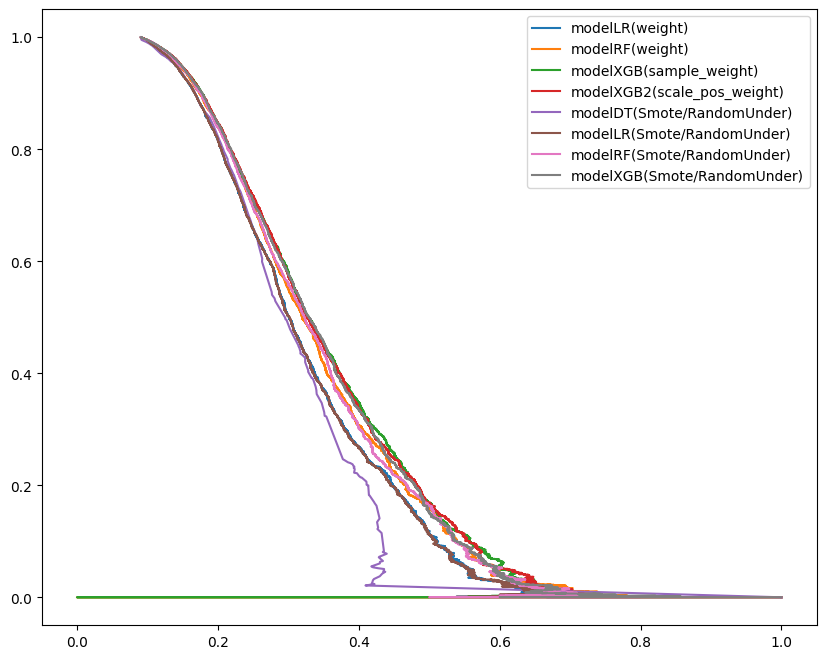

In [59]:
plt.figure(figsize=(10,8))
for i in range(len(list_model)):
    y_pred_proba = list_model[i].predict_proba(X_test)[::,1]
    precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
    # auc = roc_auc_score(y_test, y_pred_proba).round(3)
    plt.plot(precision,recall,label=list_name_model[i])
plt.legend(loc=1)
plt.show()